This is the 3rd part of the Linear Regression and web scraping project. In Parts 1 and 2, data to build the database of trails in the national parks was scraped from hikingproject.com. Now that data will be cleaned, and assessed for regression. The database was saved as an Excel file so it could be opened in a separate Jupyter Notebook (this one) and additional pings to the website are not needed. 

In [1]:
import os
from selenium import webdriver
import pandas as pd
import statsmodels.api as sm
import requests
import csv
import time
import seaborn as sns
from bs4 import BeautifulSoup as bs
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LassoCV, Lasso, Ridge, RidgeCV, ElasticNetCV
import numpy as np
import matplotlib as plt
!pip install openpyxl

# Cleaning database

In [2]:
np_trail_df=pd.read_excel('National_Park_trail_database.xlsx')
np_trail_df.head()

,Unnamed: 0,index,park_name,website,difficulty,avg_rating,num_raters,distance_(miles),high_(ft),low_(ft),up(ft),down(ft),trail_type,average_grade(%),max_grade(%),checkins,State,dog_policy
0,0,https://new.hikingproject.com/trail/7008581/br...,yellowstone_national_park,https://new.hikingproject.com/trail/7008581/br...,Intermediate/Difficult,4.7,48,0.4,7720,7473,0,248,Point to Point,13,40,103,WY,No Dogs
1,1,https://new.hikingproject.com/trail/7084138/gr...,yellowstone_national_park,https://new.hikingproject.com/trail/7084138/gr...,Easy/Intermediate,4.8,35,0.3,7357,7278,79,69,Point to Point,9,11,61,WY,No Dogs
2,2,https://new.hikingproject.com/trail/7008842/mi...,yellowstone_national_park,https://new.hikingproject.com/trail/7008842/mi...,Easy,4.6,32,0.5,7267,7226,41,11,Point to Point,2,5,102,WY,No Dogs
3,3,https://new.hikingproject.com/trail/7009016/up...,yellowstone_national_park,https://new.hikingproject.com/trail/7009016/up...,Easy,4.4,33,2.1,7369,7321,81,80,Point to Point,1,5,101,WY,No Dogs
4,4,https://new.hikingproject.com/trail/7008668/fo...,yellowstone_national_park,https://new.hikingproject.com/trail/7008668/fo...,Easy,4.6,28,0.6,7315,7288,35,27,Point to Point,2,6,107,WY,No Dogs


In [3]:
np_trail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2938 non-null   int64  
 1   index             2938 non-null   object 
 2   park_name         2938 non-null   object 
 3   website           2938 non-null   object 
 4   difficulty        2938 non-null   object 
 5   avg_rating        2938 non-null   float64
 6   num_raters        2938 non-null   int64  
 7   distance_(miles)  2938 non-null   float64
 8   high_(ft)         2938 non-null   int64  
 9   low_(ft)          2938 non-null   int64  
 10  up(ft)            2938 non-null   int64  
 11  down(ft)          2938 non-null   int64  
 12  trail_type        2938 non-null   object 
 13  average_grade(%)  2938 non-null   int64  
 14  max_grade(%)      2938 non-null   int64  
 15  checkins          2938 non-null   int64  
 16  State             2938 non-null   object 


In [4]:
# remove the extra column at the beginning and change index column to name of the trail

In [5]:
np_trail_df=np_trail_df.drop(columns='Unnamed: 0')

In [6]:
np_trail_df=np_trail_df.rename(columns={'index': 'Trail_name'})

In [7]:
np_trail_df['Trail_name']=np_trail_df.Trail_name.apply(lambda x: x.split('/')[-1].replace("-",'_'))


In [8]:
np_trail_df.head()

,Trail_name,park_name,website,difficulty,avg_rating,num_raters,distance_(miles),high_(ft),low_(ft),up(ft),down(ft),trail_type,average_grade(%),max_grade(%),checkins,State,dog_policy
0,brink_of_lower_falls_trail,yellowstone_national_park,https://new.hikingproject.com/trail/7008581/br...,Intermediate/Difficult,4.7,48,0.4,7720,7473,0,248,Point to Point,13,40,103,WY,No Dogs
1,grand_prismatic_overlook,yellowstone_national_park,https://new.hikingproject.com/trail/7084138/gr...,Easy/Intermediate,4.8,35,0.3,7357,7278,79,69,Point to Point,9,11,61,WY,No Dogs
2,midway_geyser_basin_trail,yellowstone_national_park,https://new.hikingproject.com/trail/7008842/mi...,Easy,4.6,32,0.5,7267,7226,41,11,Point to Point,2,5,102,WY,No Dogs
3,upper_geyser_basin_trail,yellowstone_national_park,https://new.hikingproject.com/trail/7009016/up...,Easy,4.4,33,2.1,7369,7321,81,80,Point to Point,1,5,101,WY,No Dogs
4,fountain_paint_pot_trail,yellowstone_national_park,https://new.hikingproject.com/trail/7008668/fo...,Easy,4.6,28,0.6,7315,7288,35,27,Point to Point,2,6,107,WY,No Dogs


Looking at the .info above, most of the rows had no issues with the scrapping and 2938 data points were scrapped for each trail. The dog column was the exception. Look at one of the actual websites where a NaN was the result:


In [9]:
null_df=np_trail_df[np_trail_df['dog_policy'].isnull()]
null_df.head()

,Trail_name,park_name,website,difficulty,avg_rating,num_raters,distance_(miles),high_(ft),low_(ft),up(ft),down(ft),trail_type,average_grade(%),max_grade(%),checkins,State,dog_policy
342,crabtree_lakes_trail,sequoia_national_park,https://www.hikingproject.com/trail/7047923/cr...,Difficult,5.0,1,3.0,11366,10440,996,84,Point to Point,7,20,0,CA,NaN
530,miguel_meadow_fire_road,yosemite_national_park,https://www.hikingproject.com/trail/7038757/mi...,Difficult,4.0,1,2.0,5210,4039,0,1171,Point to Point,11,23,0,CA,NaN
657,fan_canyon_view,joshua_tree_national_park,https://www.hikingproject.com/trail/7049288/fa...,Easy/Intermediate,5.0,1,0.3,4843,4802,2,42,Point to Point,3,6,0,CA,NaN
658,mary,joshua_tree_national_park,https://www.hikingproject.com/trail/7049392/mary,Intermediate,5.0,1,1.2,3631,3389,244,75,Point to Point,5,13,0,CA,NaN
666,contact_mine,joshua_tree_national_park,https://www.hikingproject.com/trail/7049427/co...,Intermediate/Difficult,4.5,2,1.9,3598,2926,27,698,Point to Point,7,16,0,CA,NaN


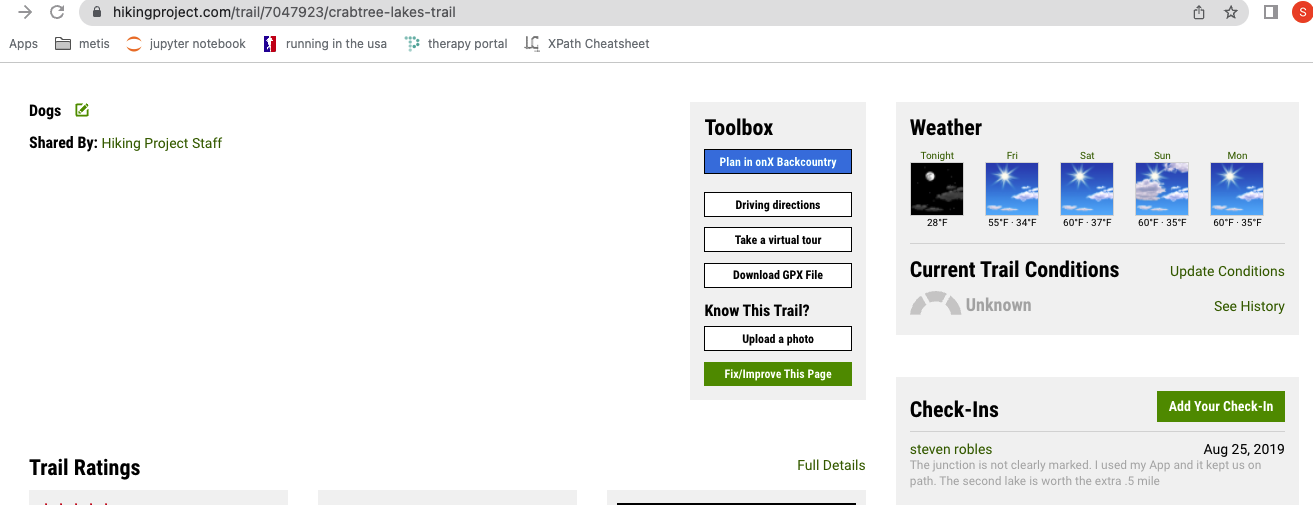

In [10]:
#On the left side of the above image, clearly noone added details about the dog policy on this trail. 
#It therefore makes sense to fill those rows with unknowns. 
np_trail_df.dog_policy=np_trail_df.dog_policy.fillna('Unknown')


One other point on the above image: Most of the data for "checkins" came from the lower right corner. On trails where larger number of checkins occured there was a button that listed the number of checkins (text was something like "See all # of checkins". Since that was not present for low number of checkins, a value of 0 was used for those rows. 

Next review number of raters. If noone rates a trail, then it is a null value that is presenting as "0" instead of "NaN". If only 1 person raters a trail there is no average just one person's opinion. 

In [11]:
np_trail_df.num_raters.value_counts()

1      704
2      466
0      414
3      316
4      230
      ... 
78       1
36       1
84       1
57       1
110      1
Name: num_raters, Length: 67, dtype: int64

There are 414 trails with 0 reviews and 704 with only one review. The 0s need to be removed because they are equivalent to a null value, and the 1s really do not provide an "average" review.

In [12]:
np_trail_df=np_trail_df[np_trail_df['num_raters']>1]
np_trail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1820 entries, 0 to 2932
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trail_name        1820 non-null   object 
 1   park_name         1820 non-null   object 
 2   website           1820 non-null   object 
 3   difficulty        1820 non-null   object 
 4   avg_rating        1820 non-null   float64
 5   num_raters        1820 non-null   int64  
 6   distance_(miles)  1820 non-null   float64
 7   high_(ft)         1820 non-null   int64  
 8   low_(ft)          1820 non-null   int64  
 9   up(ft)            1820 non-null   int64  
 10  down(ft)          1820 non-null   int64  
 11  trail_type        1820 non-null   object 
 12  average_grade(%)  1820 non-null   int64  
 13  max_grade(%)      1820 non-null   int64  
 14  checkins          1820 non-null   int64  
 15  State             1820 non-null   object 
 16  dog_policy        1820 non-null   object 


In [13]:
#Now do some cleanup on the states:
np_trail_df.State.value_counts()

CA    329
WY    173
WA    161
NC    159
CO    131
UT    123
VA    122
AZ    109
MT    107
ME    104
TX     56
OH     33
HI     23
ND     23
IN     21
MI     21
OR     18
AK     18
AR     16
SD     15
VI     11
FL     10
NV     10
NM     10
KY      7
SC      4
MN      4
TN      2
Name: State, dtype: int64

These numbers show that different parks have different number of trails. Maine (ME) for example has 1 park, and therefore 104 trails in that one park. In contrast, Utah has 5 large parks, but a total of 123 trails. Great smokey mountains and Yellowstone span several states. For consistency this analysis will assume they all occur in the same state (NC and WY respectively). Additionally, this assessment will only focus on the parks in the lower 48. Remote parks on an island or AK are hard to get to and therefore will be removed. Along those lines, Dry Tortuga NP off the florida keys will also be dropped.  Finally, rather than comparing state to state results (via dummy variables), it might makes sense to add a column for number of national parks per state. 

In [14]:
statestodrop=['HI', 'AK', "VI"# Hawaii, Alaska and the Virgin Islands
             ]
np_trail_df=np_trail_df[~np_trail_df['State'].isin(statestodrop)]
np_trail_df=np_trail_df[~np_trail_df['park_name'].str.contains('dry')] #drop dry tortugas
np_trail_df.loc[(np_trail_df.State=='TN'), 'State']='NC'
np_trail_df.loc[((np_trail_df.State=='MT') & 
                 (np_trail_df.park_name=='yellowstone_national_park')), 'State']='WY'
np_trail_df.loc[((np_trail_df.State=='NV') & 
                 (np_trail_df.park_name=='death_valley_national_park')), 'State']='CA'


# Regression Assessment

The first step is split the dataset into train test and validate models

In [15]:
X=np_trail_df.drop(columns=['num_raters'])
X=sm.add_constant(X)
y=np_trail_df['num_raters']
X, X_test, y, y_test=train_test_split(X,y,test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val=train_test_split(X,y, test_size=0.25, random_state=49)

In [16]:
X_train.shape

(1060, 17)

In [17]:
X_test.shape

(354, 17)

In [18]:
X_val.shape

(354, 17)

In [19]:
y_train.shape

(1060,)

Make a baseline summary of data with no modifications. This does not account for any dummy variables, which will be addressed next. Since the OLS score will be calculated several times, first create a function

In [20]:
def sm_model_stats(X,y):
    trail_model=sm.OLS(y,X)
    fit=trail_model.fit()
    print(fit.summary())
    return fit

In [21]:
#make the baseline assessment:
#remove text columns, num_raters (target) and checkins, because it likely correlates with num_raters
newX=X_train.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'difficulty', 'trail_type', 'State', 'dog_policy'])


In [22]:
newX.head()

,const,avg_rating,distance_(miles),high_(ft),low_(ft),up(ft),down(ft),average_grade(%),max_grade(%)
2216,1.0,4.9,2.1,8888,5771,3139,127,30,80
2915,1.0,2.4,4.1,5519,3194,2328,3,11,22
2762,1.0,4.3,7.0,4890,1591,3343,44,9,38
2232,1.0,4.2,3.6,2459,2261,234,36,1,7
2212,1.0,3.0,2.9,4549,3881,7,675,4,36


In [23]:
#test_model=sm_model_stats(newX,y_train)
trail_model_t=sm.OLS(y_train, newX)
fit_train=trail_model_t.fit()
fit_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             num_raters   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     11.55
Date:                Tue, 17 May 2022   Prob (F-statistic):           8.21e-16
Time:                        15:41:31   Log-Likelihood:                -3950.5
No. Observations:                1060   AIC:                             7919.
Df Residuals:                    1051   BIC:                             7964.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.2251      1.784     -4.610      0.000     -11.726      -4.724
avg_rating           3.7972      0.456      8.320      0.000       2.902       4.693
distance_(miles)    -0.1381      0.079     -1.743      0.082      -0.294       0.017
high_(ft)        -1.906e-05      0.000     -0.040      0.968      -0.001       0.001
low_(ft)          8.684e-05      0.000      0.182      0.856      -0.001       0.001
up(ft)               0.0007      0.000      1.593      0.111      -0.000       0.002
down(ft)            -0.0004      0.000     -0.921      0.357      -0.001       0.000
average_grade(%)     0.0491      0.079      0.618      0.537      -0.107       0.205
max_grade(%)         0.0050      0.025      0.201      0.841      -0.044       0.054
==============================================================================
Omnibus:                     1157.883   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79112.105
Skew:                           5.339   Prob(JB):                         0.00
Kurtosis:                      43.953   Cond. No.                     4.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#getting Y prediction and score for validation:
newX_val=X_val.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'difficulty', 'trail_type', 'State', 'dog_policy'])
y_val_pred=fit_train.predict(newX_val)
r2_score(y_val, y_val_pred)

0.07087861180798583

Next step is look at the values for State, dog_policy, difficulty and trail type to see if they can contribute to the analysis. 


In [25]:
np_trail_df.dog_policy.value_counts()

No Dogs      1240
Unknown       274
Leashed       249
Off-leash       5
Name: dog_policy, dtype: int64

In [26]:
#It makes sense to combine the leashed and off-leashed into "Allowed"
X_train['dog_policy']=X_train.dog_policy.replace(['Leashed', 'Off-leash'], 'Allowed')
X_test['dog_policy']=X_test.dog_policy.replace(['Leashed', 'Off-leash'], 'Allowed')
X_val['dog_policy']=X_val.dog_policy.replace(['Leashed', 'Off-leash'], 'Allowed')

In [27]:
#checking if dog policy changed the score
X_train=pd.get_dummies(X_train, columns=['dog_policy'], drop_first=True)
X_test=pd.get_dummies(X_test, columns=['dog_policy'], drop_first=True)
X_val=pd.get_dummies(X_val, columns=['dog_policy'], drop_first=True)


In [28]:
newX=X_train.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'difficulty', 'trail_type', 'State'])
test_model=sm_model_stats(newX,y_train)

                            OLS Regression Results                            
Dep. Variable:             num_raters   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     9.383
Date:                Tue, 17 May 2022   Prob (F-statistic):           4.88e-15
Time:                        15:41:31   Log-Likelihood:                -3949.8
No. Observations:                1060   AIC:                             7922.
Df Residuals:                    1049   BIC:                             7976.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.6942      1

In [29]:
#getting Y prediction and score for validation:
newX_val=X_val.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'difficulty', 'trail_type', 'State'])
y_val_pred=test_model.predict(newX_val)
r2_score(y_val, y_val_pred)

0.0753576141991461

In [30]:
#that improved the model. Looking at difficulty next:
np_trail_df.difficulty.value_counts()

Intermediate              595
Intermediate/Difficult    396
Difficult                 305
Easy/Intermediate         268
Easy                      172
Very Difficult             32
Name: difficulty, dtype: int64

In [31]:
#As the difficulty values are related it makes sense to have them assigned a numerical value. 
X_train.difficulty=X_train.difficulty.replace({'Easy': 1,
                                                       'Easy/Intermediate': 2,
                                                       'Intermediate': 3,
                                                       'Intermediate/Difficult': 4,
                                                       'Difficult':5,
                                                       'Very Difficult':6})
X_test.difficulty=X_test.difficulty.replace({'Easy': 1,
                                                       'Easy/Intermediate': 2,
                                                       'Intermediate': 3,
                                                       'Intermediate/Difficult': 4,
                                                       'Difficult':5,
                                                       'Very Difficult':6})
X_val.difficulty=X_val.difficulty.replace({'Easy': 1,
                                                       'Easy/Intermediate': 2,
                                                       'Intermediate': 3,
                                                       'Intermediate/Difficult': 4,
                                                       'Difficult':5,
                                                       'Very Difficult':6})


In [32]:
#checking the model with difficulty incorporated:
newX=X_train.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'trail_type', 'State'])
test_model=sm_model_stats(newX,y_train)

                            OLS Regression Results                            
Dep. Variable:             num_raters   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     9.080
Date:                Tue, 17 May 2022   Prob (F-statistic):           1.20e-15
Time:                        15:41:31   Log-Likelihood:                -3946.9
No. Observations:                1060   AIC:                             7918.
Df Residuals:                    1048   BIC:                             7977.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.3756      2

In [33]:
#getting Y prediction and score for validation:
newX_val=X_val.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'trail_type', 'State'])
y_val_pred=test_model.predict(newX_val)
r2_score(y_val, y_val_pred)

0.07490401206105568

In [34]:
#The next step is look at trail type to gain insights from that.
np_trail_df.trail_type.value_counts()

Point to Point    1675
Loop                79
Unknown              9
Lollipop             5
Name: trail_type, dtype: int64

This is interesting for a few reasons. 1) the data is very heavily favored for Point to Point, almost to the point where this data series is not helpful. 2) Looking at some of the trail examples that are "point to point" a hiker would realistically make it into a there and back trail. This doubles the distance and changes the hike type. This column will not be incorporated due concentration of point-to-point trails. The next step is look at the states:

In [35]:
np_trail_df.State.value_counts()

CA    329
WY    182
WA    161
NC    161
CO    131
UT    123
VA    122
AZ    109
ME    104
MT     98
TX     56
OH     33
ND     23
MI     21
IN     21
OR     18
AR     16
SD     15
NV     10
NM     10
FL     10
KY      7
SC      4
MN      4
Name: State, dtype: int64

These numbers show that different parks have different number of trails. Maine (ME) for example has 1 park, and therefore 104 trails in that one park. In contrast, Utah has 5 large parks, but a total of 123 trails. Great smokey mountains and Yellowstone span several states. For consistency this analysis will assume they all occur in the same state (NC and WY respectively). Additionally, this assessment will only focus on the parks in the lower 48. Remote parks on an island or AK are hard to get to and therefore will be removed. Along those lines, Dry Tortuga NP off the florida keys will also be dropped.  Finally, rather than comparing state to state results (via dummy variables), it might makes sense to add a column for number of national parks per state. 

Also of note- WV is missing from the list above. See future validation section at the end. 

In [36]:
npPerState={'AR':1, 'AZ':3, 'CA':9, 'CO':4, 'FL':2, 'IN':1, 'KY':1, 'ME':1, 'MI':1, 'MN':1,
            'MT':1, 'NC':1,'ND':1,'NV':1, 'NM':2, 'OH':1,'OR':1, 'SC':1, 'SD':2,
            'TX':2,'UT':5, 'VA':1, 'WA':3, 'WV':1, 'WY':2}
X_train['ParksPerState']=X_train.State.map(npPerState)
X_test['ParksPerState']=X_test.State.map(npPerState)
X_val['ParksPerState']=X_val.State.map(npPerState)

In [37]:
newX=X_train.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'trail_type', 'State'])
test_model=sm_model_stats(newX,y_train)

                            OLS Regression Results                            
Dep. Variable:             num_raters   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     8.372
Date:                Tue, 17 May 2022   Prob (F-statistic):           2.83e-15
Time:                        15:41:31   Log-Likelihood:                -3946.6
No. Observations:                1060   AIC:                             7919.
Df Residuals:                    1047   BIC:                             7984.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.3274      2

In [38]:
#getting Y prediction and score for validation:
newX_val=X_val.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'trail_type', 'State'])
y_val_pred=test_model.predict(newX_val)
r2_score(y_val, y_val_pred)

0.06505251180478744

Next rather than creating dummy variables for each state, It might make sense to do it by regions, with approximately the same number of parks per region. There are 49 parks in consideration, so 8-10 per region. They will be broken down this way:
East: everything east of the Mississippi River. (11 parks among FL, IN, KY, ME, MI, MN, NC, OH, SC, VA) (WV will be in here for future assessments). 
Cali_Nev: All parks in California and Nevada (10 total)
Northwest: This includes all parks in WA,OR,MT,ND,SD and WY (10 total)
Colorado Plateau: This includes all parks in CO and UT. Grand Canyon typically is included in conversations about the Colorado Plateau, and many visitors visit Grand Canyon and some of the Utah parks on the same trip, so it is also included here for a total of 10 parks. 
South: All parks in AR, NM, TX and AZ(minus the Grand Canyon) for a total of 7 parks.
The first step is to temporarily change the state of Grand Canyon for sorting purposes.

In [39]:
X_train.loc[(X_train.park_name=='grand_canyon_national_park'), 'State']='GC'
X_test.loc[(X_test.park_name=='grand_canyon_national_park'), 'State']='GC'
X_val.loc[(X_val.park_name=='grand_canyon_national_park'), 'State']='GC'


In [40]:
park_regions={'AR':'South', 'AZ':'South', 'CA':'CANV', 'CO':'Co_Plat', 'GC':'Co_Plat', 'FL':'East', 'IN':'East', 
              'KY':'East', 'ME':'East', 'MI':'East', 'MN':'East', 'MT':'NorthWest', 'NC':'East','ND':'NorthWest',
              'NV':'CANV', 'NM':'South', 'OH':'East','OR':'NorthWest', 'SC':'East', 'SD':'NorthWest', 
              'TX':'South','UT':'Co_Plat', 'VA':'East', 'WA':'NorthWest', 'WV':'East','WY':'NorthWest'}
X_train['region']=X_train.State.map(park_regions)
X_test['region']=X_test.State.map(park_regions)
X_val['region']=X_val.State.map(park_regions)

In [41]:
#switch GC back to AZ
X_train.loc[(X_train.park_name=='grand_canyon_national_park'), 'State']='AZ'
X_test.loc[(X_test.park_name=='grand_canyon_national_park'), 'State']='AZ'
X_val.loc[(X_val.park_name=='grand_canyon_national_park'), 'State']='AZ'

In [42]:
X_train=pd.get_dummies(X_train, columns=['region'], drop_first=True)
X_test=pd.get_dummies(X_test, columns=['region'], drop_first=True)
X_val=pd.get_dummies(X_val, columns=['region'], drop_first=True)

In [43]:
newX=X_train.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'trail_type', 'State'])
test_model=sm_model_stats(newX,y_train)

                            OLS Regression Results                            
Dep. Variable:             num_raters   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     7.647
Date:                Tue, 17 May 2022   Prob (F-statistic):           2.63e-17
Time:                        15:41:31   Log-Likelihood:                -3936.4
No. Observations:                1060   AIC:                             7907.
Df Residuals:                    1043   BIC:                             7991.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -11.2869      4

In [44]:
#getting Y prediction and score for validation:
newX_val=X_val.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'trail_type', 'State'])
y_val_pred=test_model.predict(newX_val)
r2_score(y_val, y_val_pred)

0.08539964579204529

Next, looking at the table some columns are similar. high(ft) refers to the highest elevation of the trail, and low(ft) refers to the lowest elevation of the trail. Similarly up and down refer to how much a hiker hikes on an incline vs a decline. Because a trail sometimes can have a valley in the middle of an ascent low + up does not exactly equal high, but it is close. Removing down or low actually hurts R^2, and since they do measure different things it was decided to keep both in the analysis. 

The next thing to do is look at the pair plots to see if other trends can be identified.Y has to be added back to the dataframe

In [45]:
pairplottrain=X_train
pairplottrain['num_raters']=y_train

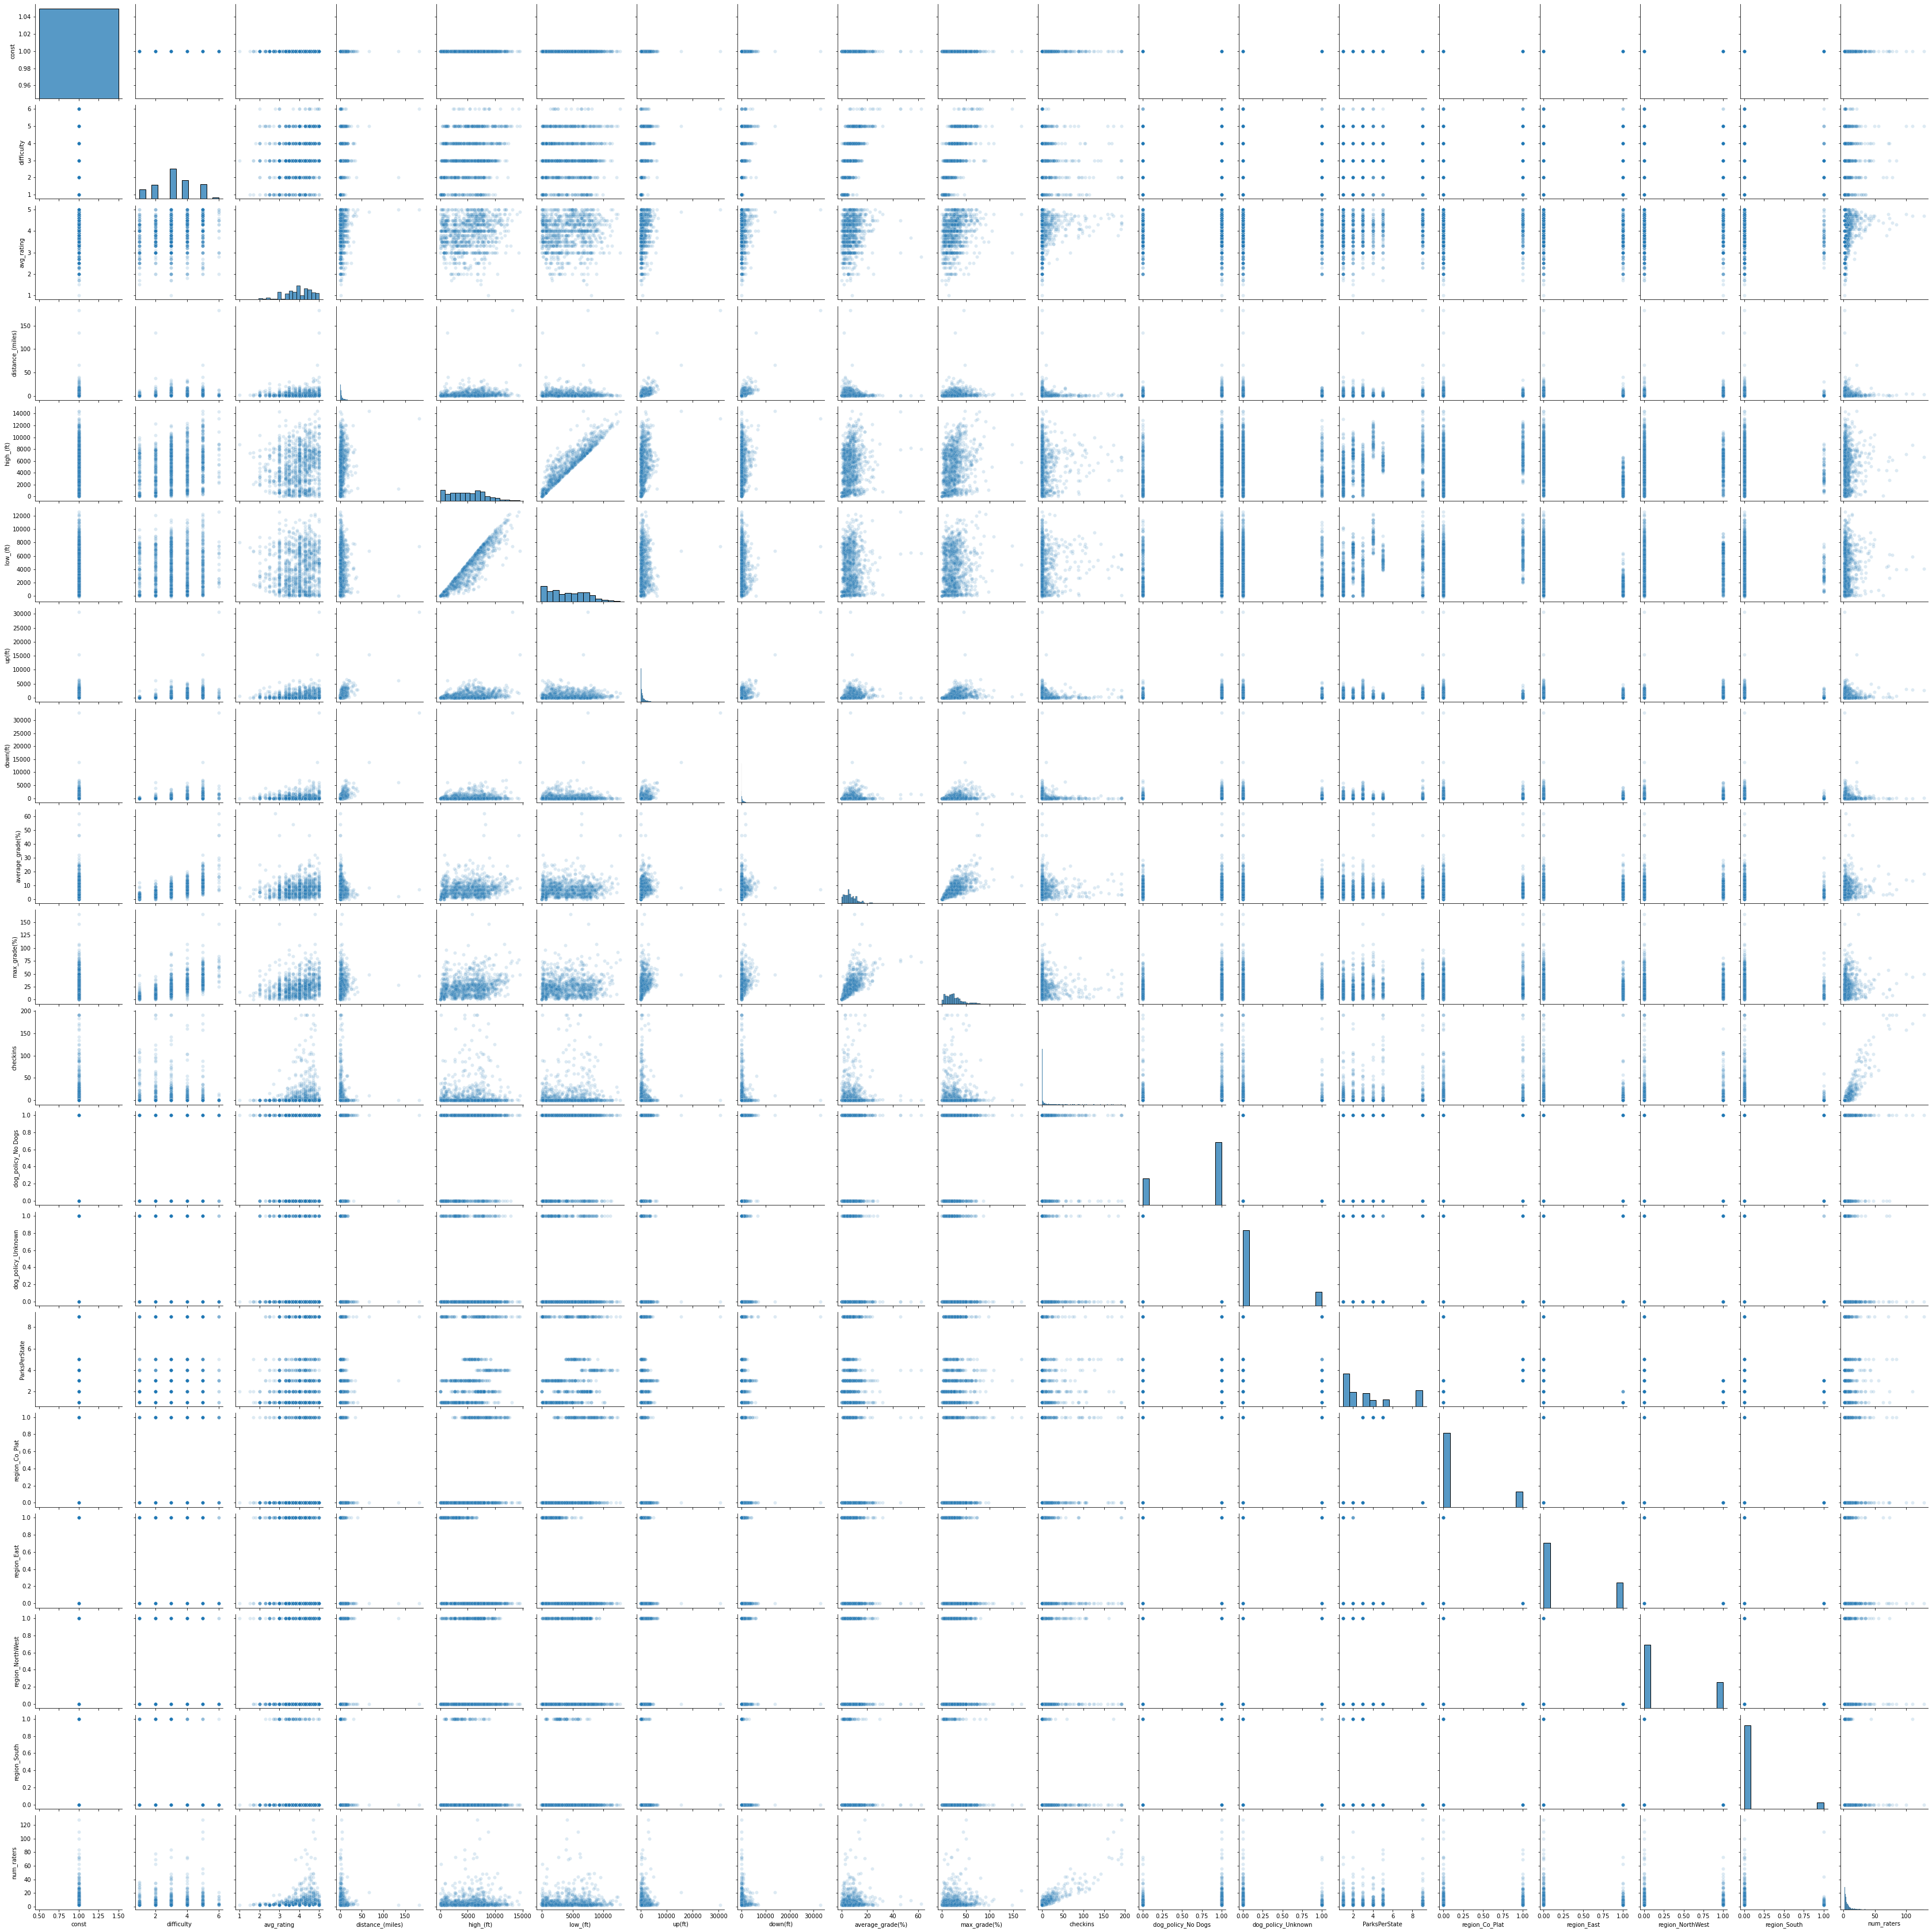

In [46]:
sns.pairplot(pairplottrain, plot_kws={'alpha':0.15})

Looking at these charts, it seems there is a quadratic or log option for avg_rating and distance. Try quadratic for avg rating first

In [47]:
#This added numraters to X_train so it needs to be removed:
X_train=X_train.drop(columns='num_raters')

In [48]:
X_train['rating_sq']=X_train['avg_rating']**2
X_test['rating_sq']=X_test['avg_rating']**2
X_val['rating_sq']=X_val['avg_rating']**2

In [49]:
newX=X_train.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'trail_type', 'State'])
test_model=sm_model_stats(newX,y_train)

                            OLS Regression Results                            
Dep. Variable:             num_raters   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     7.490
Date:                Tue, 17 May 2022   Prob (F-statistic):           9.98e-18
Time:                        15:42:05   Log-Likelihood:                -3934.1
No. Observations:                1060   AIC:                             7904.
Df Residuals:                    1042   BIC:                             7994.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.0006      7

In [50]:
#getting Y prediction and score for validation:
newX_val=X_val.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'trail_type', 'State'])
y_val_pred=test_model.predict(newX_val)
r2_score(y_val, y_val_pred)

0.0968571435219805

The next step is test the log for distance_(miles)

In [51]:
X_train['log_distance']=np.log(1+X_train['distance_(miles)'])
X_test['log_distance']=np.log(1+X_test['distance_(miles)'])
X_val['log_distance']=np.log(1+X_val['distance_(miles)'])

In [52]:
newX=X_train.drop(columns=['Trail_name','checkins', 'park_name', 'website', 'trail_type', 'State'])
test_model=sm_model_stats(newX,y_train)

                            OLS Regression Results                            
Dep. Variable:             num_raters   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     7.458
Date:                Tue, 17 May 2022   Prob (F-statistic):           1.79e-18
Time:                        15:42:05   Log-Likelihood:                -3930.9
No. Observations:                1060   AIC:                             7900.
Df Residuals:                    1041   BIC:                             7994.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.7619      7

This seems as accurate as possible. Now test the validation section.

In [53]:
#getting Y prediction and score for validation:
newX_val=X_val.drop(columns=['Trail_name', 'checkins', 'park_name', 'website', 'trail_type', 'State'])
y_val_pred=test_model.predict(newX_val)
r2_score(y_val, y_val_pred)

0.09731625108190745

Validation is a bit lower, and has been since introduced parks per state. However there is not much difference at this point and so it likely was caused by an outlier. 

Final R2 for train data: 0.114 (increase of 0.033 from initial score of 0.081)
Final R2 for validation data: 0.097 (increase of 0.027 from initial score of 0.070)

Now combine train and validate, and run it on test data. 

In [56]:
X_train_val=pd.concat([X_train, X_val])
y_train_val=pd.concat([y_train,y_val])



In [54]:
#make model to use with test
#newX_train=X_train.drop(columns=['Trail_name','checkins', 'park_name', 'website', 'trail_type', 'State'])
#trail_model_t=sm.OLS(y_train, newX_train)
#fit_train=trail_model_t.fit()
#fit_train.summary()

In [57]:
#make new model to run with test data
newX_t_v=X_train_val.drop(columns=['Trail_name','checkins', 'park_name', 'website', 'trail_type', 'State'])
tv_model=sm_model_stats(newX_t_v,y_train_val)

#y_t_val_pred=fit_train.predict(newX_t_v)
#r2_score(y_train_val,y_t_val_pred)

                            OLS Regression Results                            
Dep. Variable:             num_raters   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     10.44
Date:                Tue, 17 May 2022   Prob (F-statistic):           3.35e-28
Time:                        15:54:10   Log-Likelihood:                -5190.2
No. Observations:                1414   AIC:                         1.042e+04
Df Residuals:                    1395   BIC:                         1.052e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9296      6

In [60]:
newX_test=X_test.drop(columns=['Trail_name','checkins', 'park_name', 'website', 'trail_type', 'State'])
y_test_pred=tv_model.predict(newX_test)
r2_score(y_test,y_test_pred)

0.12402004054342197

# Future testing

In December 2020, New River Gorge National Park in West Virginia was designated a National Park. Towards the end of the project, it was noticed that WV was not listed on the list of States home to a National Park. Hiking project had not updated their website to include this new park so it was not included in the database. If this trail websites for this park are scrapped, they can provide an extra validation/test dataset to see how well the model works on the trails of this park. 